In [93]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from textblob import TextBlob
from textblob import Word
import os
import pandas as pd
from nltk.stem import PorterStemmer
import pickle

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\20111\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [94]:
start_directory = "20news-18828/"

articles_list = []
# Walk through all directories and files starting from the start_directory
for root, dirs, files in os.walk(start_directory):
    folder = root.replace(start_directory , "")
    if folder == "":
        continue
    for file_name in files:
        file_path = os.path.join(root, file_name)
        with open(file_path, "r", encoding="latin1") as file:
            file_contents = file.read()
            row_list = [file_contents, folder]
            articles_list.append(row_list)
            
articles = pd.DataFrame(articles_list, columns=['Articles', 'Group'])

articles

,Articles,Group
0,From: mathew <mathew@mantis.co.uk>\nSubject: A...,alt.atheism
1,From: mathew <mathew@mantis.co.uk>\nSubject: A...,alt.atheism
2,From: I3150101@dbstu1.rz.tu-bs.de (Benedikt Ro...,alt.atheism
3,From: mathew <mathew@mantis.co.uk>\nSubject: R...,alt.atheism
4,From: strom@Watson.Ibm.Com (Rob Strom)\nSubjec...,alt.atheism
...,...,...
18823,From: sbuckley@fraser.sfu.ca (Stephen Buckley)...,talk.religion.misc
18824,From: bakerj@gtephx.UUCP (Jon Baker)\nSubject:...,talk.religion.misc
18825,From: pharvey@quack.kfu.com (Paul Harvey)\nSub...,talk.religion.misc
18826,From: <KEVXU@CUNYVM.BITNET>\nSubject: Re: Info...,talk.religion.misc


In [95]:
words_to_delete = [
    "From:",
    "Subject:",
    "Archive-name:",
    "Alt-atheism-archive-name:",
    "Last-modified:",
    "Version:",
    "In article",
    "> In article",
    "-----BEGIN PGP SIGNED MESSAGE-----"
]
#filtered_articles =  articles[~articles['Articles'].str.startswith(tuple(words_to_delete))]
def remove_lines(article):
    lines = article.split('\n')
    filtered_lines = [line for line in lines if not any(line.startswith(word) for word in words_to_delete)]
    return '\n'.join(filtered_lines)

# Apply the function to each article in the DataFrame
articles['Articles'] = articles['Articles'].apply(remove_lines)
articles

,Articles,Group
0,\n\n Atheist Reso...,alt.atheism
1,\n\n\n An Introductio...,alt.atheism
2,\nmangoe@cs.umd.edu (Charley Wingate) writes:\...,alt.atheism
3,\ndmn@kepler.unh.edu (...until kings become ph...,alt.atheism
4,"\n\n|> [1] HOWEVER, I hate economic terrorism ...",alt.atheism
...,...,...
18823,\npboxrud@magnus.acs.ohio-state.edu (Paul D Bo...,talk.religion.misc
18824,\n> > In <C5sqyA.F7v@noose.ecn.purdue.edu> tbr...,talk.religion.misc
18825,\nbill@emx.cc.utexas.edu (Bill Jefferys) write...,talk.religion.misc
18826,\n\nqpalo@digi.lonestar.org (Gerry Palo)\n\n>T...,talk.religion.misc


In [96]:
endStrings_remove = [
    "writes:",
    "wrote:"
]

def remove_lines_ending_with(article):
    lines = article.split('\n')
    filtered_lines = [line for line in lines if not any(line.endswith(word) for word in endStrings_remove)]
    output_string = '\n'.join(filtered_lines)
    return output_string

articles['Articles'] = articles['Articles'].apply(remove_lines_ending_with)
articles

,Articles,Group
0,\n\n Atheist Reso...,alt.atheism
1,\n\n\n An Introductio...,alt.atheism
2,"\n \n>>Well, John has a quite different, not n...",alt.atheism
3,"\n> Recently, RAs have been ordered (and ...",alt.atheism
4,"\n\n|> [1] HOWEVER, I hate economic terrorism ...",alt.atheism
...,...,...
18823,\n\n> I wasn't sure if this was the right ...,talk.religion.misc
18824,"\n> > |Probably not. But then, I don't pack h...",talk.religion.misc
18825,\n>If you would like to understand better the ...,talk.religion.misc
18826,\n\nqpalo@digi.lonestar.org (Gerry Palo)\n\n>T...,talk.religion.misc


In [97]:
line_to_remove = "-----BEGIN PGP SIGNATURE-----"
def remove_lines_after_pgp(article):
    lines = article.split('\n')
    try:
        index_to_remove = lines.index(line_to_remove)
        lines = lines[:index_to_remove]  # Keep the line_to_keep and all lines before it
    except ValueError:
        pass  # Line not found, keep all lines
    return '\n'.join(lines)


articles['Articles'] = articles['Articles'].apply(remove_lines_after_pgp)
articles

,Articles,Group
0,\n\n Atheist Reso...,alt.atheism
1,\n\n\n An Introductio...,alt.atheism
2,"\n \n>>Well, John has a quite different, not n...",alt.atheism
3,"\n> Recently, RAs have been ordered (and ...",alt.atheism
4,"\n\n|> [1] HOWEVER, I hate economic terrorism ...",alt.atheism
...,...,...
18823,\n\n> I wasn't sure if this was the right ...,talk.religion.misc
18824,"\n> > |Probably not. But then, I don't pack h...",talk.religion.misc
18825,\n>If you would like to understand better the ...,talk.religion.misc
18826,\n\nqpalo@digi.lonestar.org (Gerry Palo)\n\n>T...,talk.religion.misc


In [98]:
pattern = r'.*@.*'
def remove_lines_starting_with_regex(article):
    lines = article.split('\n')
    filtered_lines = [line for line in lines if not re.match(pattern, line)]
    output_string = '\n'.join(filtered_lines)
    return output_string

articles['Articles'] = articles['Articles'].apply(remove_lines_starting_with_regex)
articles

,Articles,Group
0,\n\n Atheist Reso...,alt.atheism
1,\n\n\n An Introductio...,alt.atheism
2,"\n \n>>Well, John has a quite different, not n...",alt.atheism
3,"\n> Recently, RAs have been ordered (and ...",alt.atheism
4,"\n\n|> [1] HOWEVER, I hate economic terrorism ...",alt.atheism
...,...,...
18823,\n\n> I wasn't sure if this was the right ...,talk.religion.misc
18824,"\n> > |Probably not. But then, I don't pack h...",talk.religion.misc
18825,\n>If you would like to understand better the ...,talk.religion.misc
18826,\n\n\n>The danger of anti-cult groups is that ...,talk.religion.misc


In [99]:
stop_words = stopwords.words('english')

In [100]:
articles['Articles'] = articles['Articles'].apply(lambda x: " ".join(x.lower() for x in x.split()))
articles['Articles'] = articles['Articles'].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

articles

,Articles,Group
0,atheist resources addresses atheist organizati...,alt.atheism
1,introduction atheism article attempts provide ...,alt.atheism
2,">>well, john quite different, necessarily elab...",alt.atheism
3,"> recently, ras ordered (and none resisted car...",alt.atheism
4,"|> [1] however, hate economic terrorism politi...",alt.atheism
...,...,...
18823,"> sure right newsgroup post to, guess >the mis...",talk.religion.misc
18824,"> > |probably not. then, pack heavy weaponry i...",talk.religion.misc
18825,>if would like understand better sort behavior...,talk.religion.misc
18826,>the danger anti-cult groups expose lot >decep...,talk.religion.misc


In [101]:
#def remove_non_alphanumeric(article):
 #   return ''.join(char for char in article if char.isalnum() or char.isspace())

#output = remove_non_alphanumeric("alpha_numeric, one.;")

#articles['Articles'] = articles['Articles'].apply(remove_non_alphanumeric)
#articles
#output

In [102]:
punctuations = '.,_'
def remove_non_alphanumeric(article):
    allowed_characters = string.ascii_letters + string.digits + punctuations + ' '
    output_string = ''.join(char for char in article if char in allowed_characters)
    return output_string
articles['Articles'] = articles['Articles'].apply(remove_non_alphanumeric)
st = PorterStemmer()
articles['Articles'] = articles['Articles'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
#articles['Articles'] =articles['Articles'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
articles

,Articles,Group
0,atheist resourc address atheist organ usa free...,alt.atheism
1,introduct atheism articl attempt provid gener ...,alt.atheism
2,"well, john quit different, necessarili elabor ...",alt.atheism
3,"recently, ra order and none resist care appar ...",alt.atheism
4,"1 however, hate econom terror polit correct wo...",alt.atheism
...,...,...
18823,"sure right newsgroup post to, guess the misc r...",talk.religion.misc
18824,"probabl not. then, pack heavi weaponri intent ...",talk.religion.misc
18825,if would like understand better sort behavior ...,talk.religion.misc
18826,"the danger anticult group expos lot deception,...",talk.religion.misc


In [103]:
articles['Articles'][1]

'introduct atheism articl attempt provid gener introduct atheism. whilst tri neutral possibl regard contenti issues, alway rememb document repres one viewpoint. would encourag read wide draw conclus relev book list companion article. provid sens cohes progression, present articl imaginari convers atheist theist. question ask imaginari theist question crop repeatedli alt.ath sinc newsgroup created. frequent ask question answer companion article. pleas note articl arguabl slant toward answer question pose christian viewpoint. faq file reflect question actual asked, predominantli christian proselyt alt.atheism. talk religion, talk primarili religion christianity, judaism islam, involv sort superhuman divin being. much discuss appli religions, may not. what atheism atheism character absenc belief exist god. atheist go further, believ god exist. former often refer weak atheist position, latter strong atheism. import note differ two positions. weak atheism simpl sceptic disbelief exist god. 

In [104]:
train_x,valid_x,train_y,valid_y=model_selection.train_test_split(articles['Articles'],articles['Group'])
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(articles['Articles'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

xtrain_tfidf.data

array([0.12188414, 0.08501545, 0.13572353, ..., 0.06604609, 0.14830514,
       0.10591854])

In [105]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)
    accuracy = metrics.accuracy_score(predictions, valid_y)
    print ("Accuracy: ", accuracy)
    #visualize the model
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5,10.5)
    CM = confusion_matrix( predictions,valid_y )
    sns.heatmap(CM, annot=True,xticklabels=articles['Group'].unique(),yticklabels=articles['Group'].unique())
    ax.xaxis.set_label_position("top")
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

Accuracy:  0.8427873380072233


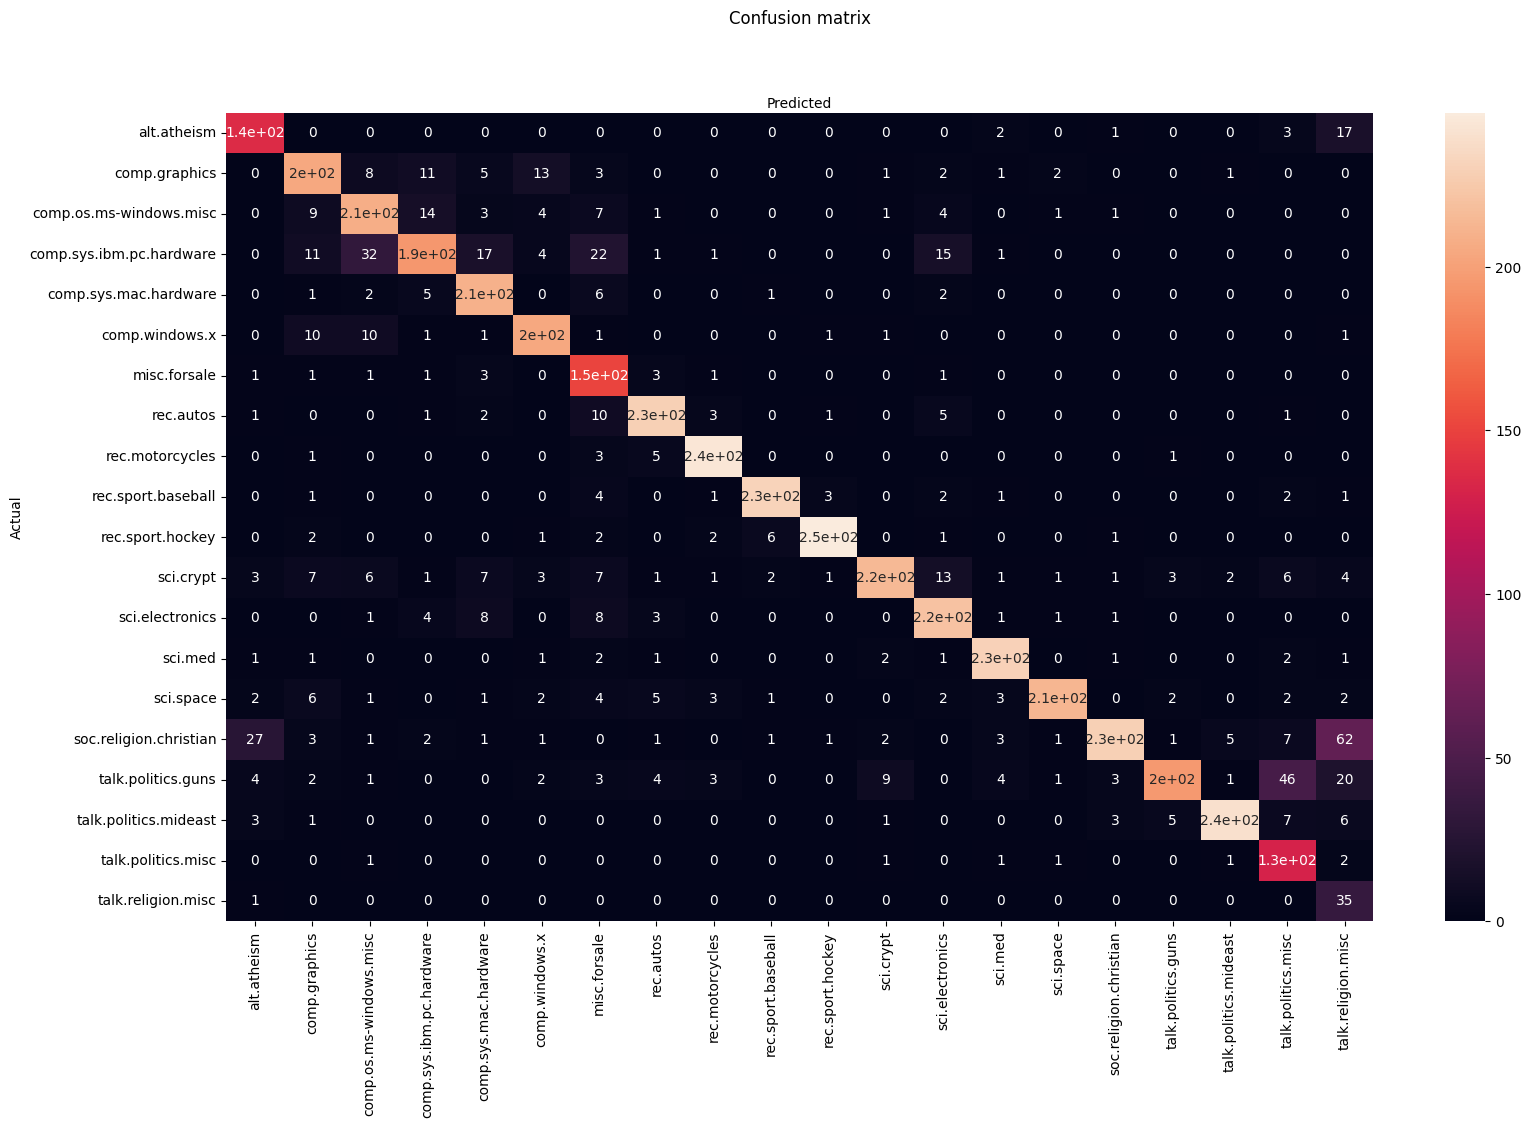

In [106]:
train_model(naive_bayes.MultinomialNB(alpha=0.2), xtrain_tfidf, train_y, xvalid_tfidf)


Accuracy:  0.8393881453154876


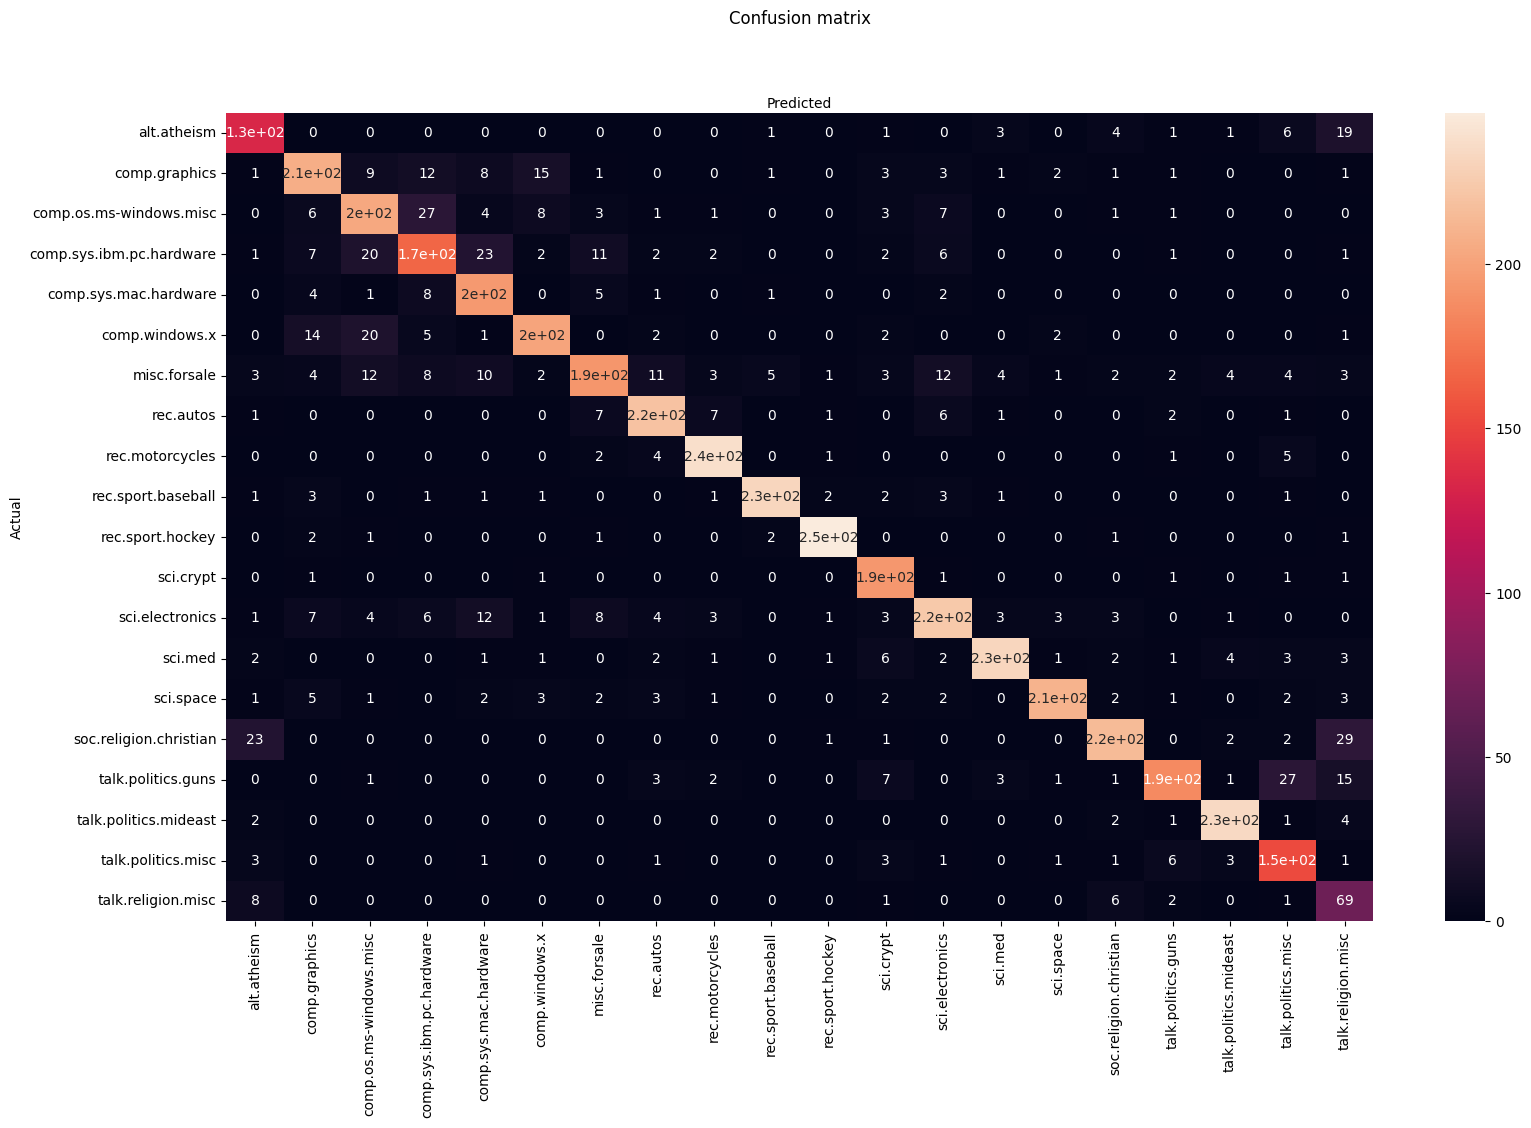

In [107]:
train_model(linear_model.LogisticRegression(), xtrain_tfidf, train_y, xvalid_tfidf)

In [108]:
#save logistic model
model = linear_model.LogisticRegression()
model.fit(xtrain_tfidf, train_y)
filename = 'logistic.sav'
pickle.dump(model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(xvalid_tfidf, valid_y)
print(result)

0.8393881453154876


In [109]:
#save naive bayes model
model = naive_bayes.MultinomialNB(alpha=0.2)
model.fit(xtrain_tfidf, train_y)
filename = 'naive.sav'
pickle.dump(model, open(filename, 'wb'))
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(xvalid_tfidf, valid_y)
print(result)

0.8427873380072233
